# DSC180A Causal Discovery of Remote Work and Mental Health
group members: Evelyn, Vivan, Jason, Yishan

In [1]:
#!pip install causal-learn
#!pip install --upgrade matplotlib

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##  Data simulation

In [2]:
np.random.seed(0)
n = 5000

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Independent and confounding variables
education_level = np.random.choice(['high_school', 'bachelor', 'master', 'doctorate'], size=n)
extroverted = np.random.choice([0, 1], size=n)  # 0 for introverted, 1 for extroverted

# Define education effect based on education level
education_map = {'high_school': 1, 'bachelor': 2, 'master': 3, 'doctorate': 4}
education_effect = np.array([education_map[edu] for edu in education_level])

# Adjust average daily work hours based on education level
average_daily_work_hours = np.clip(8 + np.random.normal(0, 1, size=n) + education_effect, 0, 16)

# Adjust family member number based on education level
family_member_number = np.clip(2 + np.random.poisson(1, size=n) - education_effect, 0, 10)

# Influence of extroverted on exercise level and social interaction
exercise_level = np.clip(2 + np.random.normal(0, 1, size=n) + extroverted, 0, 4)

# Simulate other variables
company_support_for_mental_support = np.random.randint(1, 6, size=n)

# Work location influenced by company mental support
p_remote = sigmoid((company_support_for_mental_support - 3) * 0.5)
work_location = np.where(
    np.random.rand(n) < p_remote,
    np.random.choice(['remote', 'hybrid'], size=n, p=[0.6, 0.4]),
    'onsite'
)

# Social Isolation Rating influenced by family members and work location, moderated by extroversion
social_isolation_base = np.where(
    work_location == 'remote',
    3 + np.random.normal(0, 0.5, size=n),
    np.where(
        work_location == 'hybrid',
        2 + np.random.normal(0, 0.5, size=n),
        1 + np.random.normal(0, 0.5, size=n)
    )
)
social_isolation_rating = np.clip(social_isolation_base + np.log1p(family_member_number) - extroverted, 1, 5)

# Sleep Quality influenced by work hours and exercise
sleep_quality = np.clip(2 - np.power((average_daily_work_hours / 10), 2) + exercise_level, 0, 4)

# Adjusted Stress Level using sin(x) + 0.8x
stress_level = np.clip(
    np.sin(social_isolation_rating) + 0.8 * social_isolation_rating + (4 - sleep_quality) + np.random.normal(0, 0.5, size=n),
    1, 10
)

# Compile results into a DataFrame
data = {
    "Family_Members": family_member_number,
    "Company_Support": company_support_for_mental_support,
    "Work_Location": work_location,
    "Social_Isolation_Rating": social_isolation_rating,
    "Sleep": sleep_quality,
    "Stress_Level": stress_level,
    "Education_Level": education_level,
    "Extroverted": extroverted,
    "Exercise_Level": exercise_level,
    "Average_Daily_Work_Hours": average_daily_work_hours
}

data = pd.DataFrame(data)

In [3]:
#convert categorical columns to numerical labels
data['Work_Location'] = data['Work_Location'].map({'onsite': 1, 'hybrid': 2, 'remote': 3})
data["Education_Level"] = pd.Series(education_level).map({'high_school': 1, 'bachelor': 2, 'master': 3, 'doctorate': 4}).values

In [4]:
data

,Family_Members,Company_Support,Work_Location,Social_Isolation_Rating,Sleep,Stress_Level,Education_Level,Extroverted,Exercise_Level,Average_Daily_Work_Hours
0,1,4,1,1.000000,4.000000,1.598186,1,1,4.000000,7.578096
1,0,2,1,1.000000,1.169698,3.827589,4,0,0.393816,11.063991
2,1,1,1,1.000000,3.477512,1.149310,2,1,2.438587,9.803443
3,3,1,1,1.000000,3.614454,1.007035,1,1,2.324262,8.425012
4,0,3,3,3.293175,3.241105,3.565357,4,0,2.866853,12.750483
...,...,...,...,...,...,...,...,...,...,...
4995,1,4,2,2.356483,2.559473,4.113974,4,0,2.145069,12.592046
4996,0,5,1,1.000000,4.000000,1.393576,2,1,4.000000,10.009057
4997,0,1,2,1.384344,1.494679,4.494597,4,0,0.729818,11.113678
4998,3,3,1,1.000000,4.000000,1.670860,2,1,3.289979,10.049100


In [5]:
data.to_csv('data.csv', index=False)

# EDA

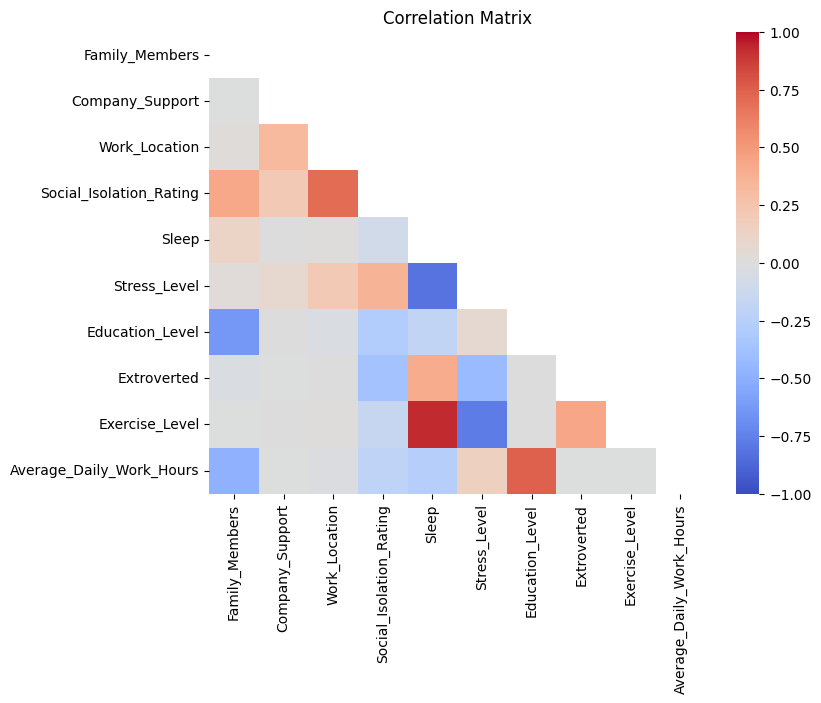

In [6]:
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

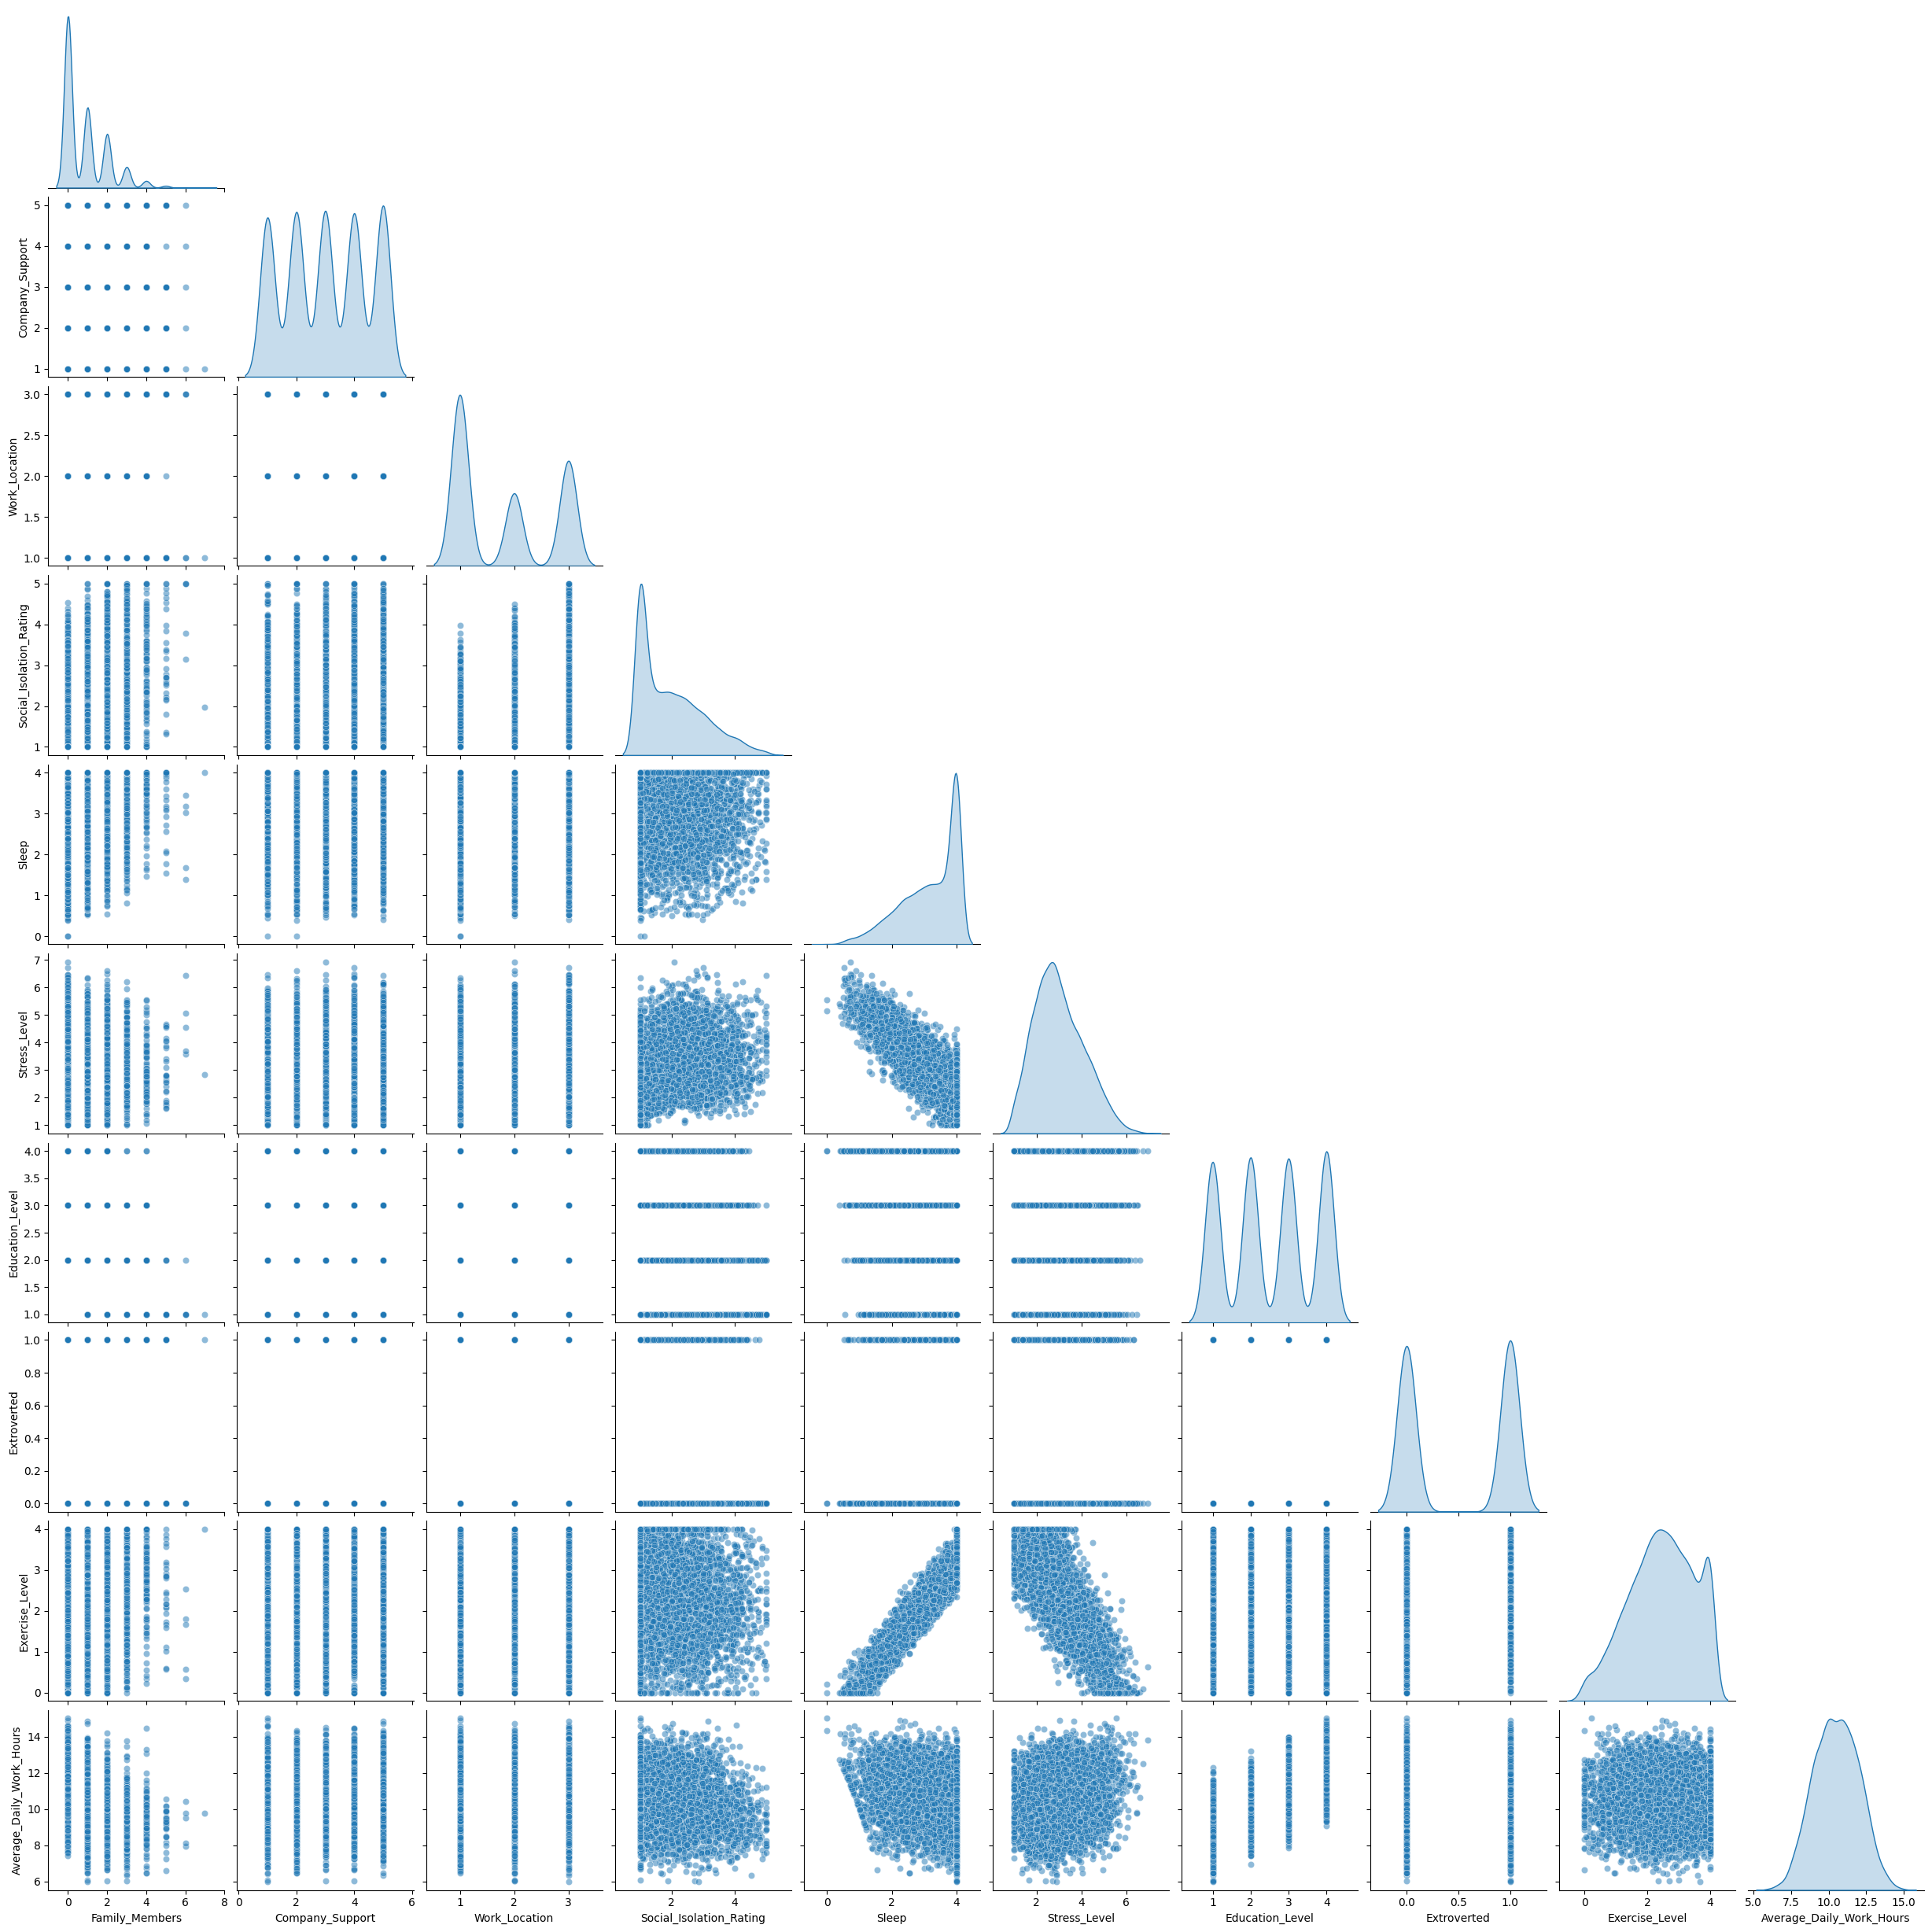

In [10]:
sns.pairplot(data, diag_kind='kde', plot_kws={'alpha': 0.5}, corner=True)
plt.show()